# Makemore part 3

## The main goals in this lecture it seems
Is to basically improve the NN we've already made by tweaking things (mainly parameters) so we get better losses in the same amount of time. We fix the softmax, tanh saturation, .... All to get better losses  heheh.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [2]:
# read in all the words
words = open('../2 - makemore/names.txt', 'r').read().splitlines()
words[:8]
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
len(words)

32033

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [32]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [87]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2# tanh part; make hpreact closer to 0
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # tanh bit
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # initial loss
b2 = torch.randn(vocab_size,                      generator=g) * 0 # for initial loss

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [88]:
# same optimisation as last time
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/  20000: 3.3091


In [89]:
h

tensor([[ 0.7804,  0.8365, -0.8348,  ...,  0.0291, -0.2120, -0.9624],
        [ 0.4169, -0.3410,  0.5206,  ..., -0.6272,  0.4202,  0.3333],
        [-0.7192, -0.7557, -0.9463,  ...,  0.0857, -0.9332, -0.5327],
        ...,
        [-0.8133,  0.6107, -0.4489,  ...,  0.3138,  0.4857,  0.7836],
        [ 0.3917, -0.6125,  0.1376,  ...,  0.1823, -0.8834,  0.2004],
        [-0.3785, -0.6293, -0.8051,  ..., -0.5670, -0.8055, -0.0038]],
       grad_fn=<TanhBackward0>)

In [83]:
logits.shape # much closer to 0 now -> initial loss is close to equal prob distr. one (~3.3). || On the initial loss

torch.Size([32, 27])

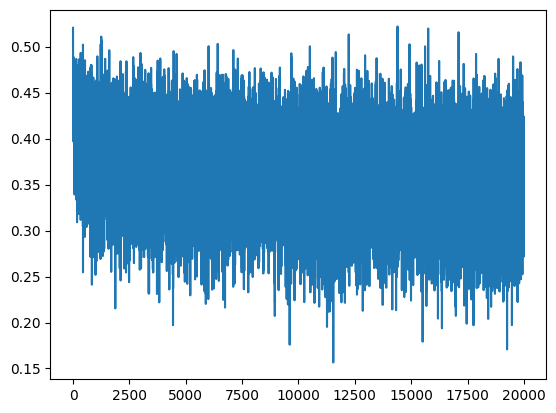

In [72]:
plt.plot(lossi)

In [77]:
@torch.no_grad() # this decorator disables gradient tracking, i.e tells torch we won't need gradients for anything in this tensor -- makes stuff more efficient 
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)

  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.222252368927002
val 2.260493516921997


In [9]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1,-1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

nartavea.
jahmer.
kamri.
rahty.
halans.
esrah.
brad.
karra.
areei.
arroni.
jamaiir.
asleigh.
ham.
adre.
quint.
anlengh.
jazii.
ware.
andearyxi.
akcer.


First thing -- our initialised parameters are munted. Like, we start at ~28 and go to ~2.8 straight away, and then stay there for a bit.
The "hockey stick" of the graph is simply because your initial was so terrible that there's a massive difference.
Basically, you should always have a rough idea of what your initial loss should be when training NNs.

In our case; we'd want every possibility to be equally likely -- all chars should be the same prob; we have no reason not to believe this initially (i.e each char should have 1/27 prob).
(This is basically last video's exercise so :O )


In [42]:
# So to get the loss:
-torch.tensor(1/27).log() # This would be loss for an equal prob. distribution model
# Example with a 4 tensor thing
def initial_loss_example(tensor_nums = None):
	if tensor_nums == None:
		logits = torch.randn(4) * 100
	else:
		logits = torch.tensor(tensor_nums)
	probs = F.softmax(logits, dim=0 )
	loss = -probs[2].log() # Select random
	print(f'{logits=}, {probs=}, {loss=}')	
initial_loss_example([0.0,0.0,5.0, 0])
## Basically, the logits would initially be random; sometimes you would luck out and get a good probability (high # in the element you want), but way more likely you'd get trash
initial_loss_example([6.0,0.0,-1.0, 4.0])
initial_loss_example()
""" And if your logits are big, your loss is even bigger. Big enough, you'd get infinity!"""
initial_loss_example([60.0,0.0,-1.0, 40.0])
initial_loss_example([60.0,210.0,86.0, 100.0])
"""
So we want logits to be ~0 when network is initialised. Or equal, since the normalisation yknow ;P

This means, well, we don't want to add a bias to the final logits bit so *0, and we'll make the weights REAAAALLLY small (but not *0 or something to do with symmetry/symmetry breaking; apparently it'd be fine in this case but best not to. It's probably something like you effectively make that whole set of weights useless or something???) Okay let's go!
/// 12:00 okay so we fixed it, now our initial loss is way better @ ~3.3, and our graph doesn't look like a hockey stick anymore (no easy gains). Very nice!

=> Also end up getting better test results :D (since we have more time *actually* optimising the NN outputs & loss).
"""



logits=tensor([0., 0., 5., 0.]), probs=tensor([0.0066, 0.0066, 0.9802, 0.0066]), loss=tensor(0.0200)
logits=tensor([ 6.,  0., -1.,  4.]), probs=tensor([8.7817e-01, 2.1768e-03, 8.0079e-04, 1.1885e-01]), loss=tensor(7.1299)
logits=tensor([ 83.7711,  50.1836,   2.8031, -92.8799]), probs=tensor([1.0000e+00, 2.5891e-15, 6.8559e-36, 0.0000e+00]), loss=tensor(80.9680)
logits=tensor([60.,  0., -1., 40.]), probs=tensor([1.0000e+00, 8.7565e-27, 3.2213e-27, 2.0612e-09]), loss=tensor(61.)
logits=tensor([ 60., 210.,  86., 100.]), probs=tensor([0., 1., 0., 0.]), loss=tensor(inf)


"\nSo we want logits to be ~0 when network is initialised. Or equal, since the normalisation yknow ;P\n\nThis means, well, we don't want to add a bias to the final logits bit so *0, and we'll make the weights REAAAALLLY small (but not *0 or something to do with symmetry/symmetry breaking; apparently it'd be fine in this case but best not to. It's probably something like you effectively make that whole set of weights useless or something???) Okay let's go!\n/// 12:00 okay so we fixed it, now our initial loss is way better @ ~3.3, and our graph doesn't look like a hockey stick anymore (no easy gains). Very nice!\n"

### Fixing our saturated tanh ~15:00
Okay, so that's cool. But *there's another* problem lurking in our midst!
notice:

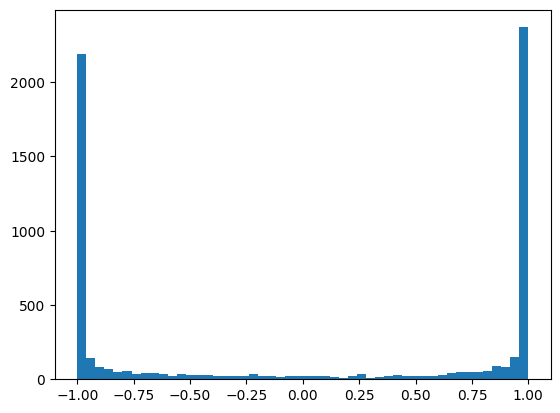

In [56]:
plt.hist(h.view(-1).tolist(),50); # h is (32,200), h.view(-1) -> [(6400)], then convert to a list so plt can read it nicely 

# Hm.... A lot of our values are either at 1, or -1... Let's look at hpreact, which is the tensor that gets tanh'd into h.


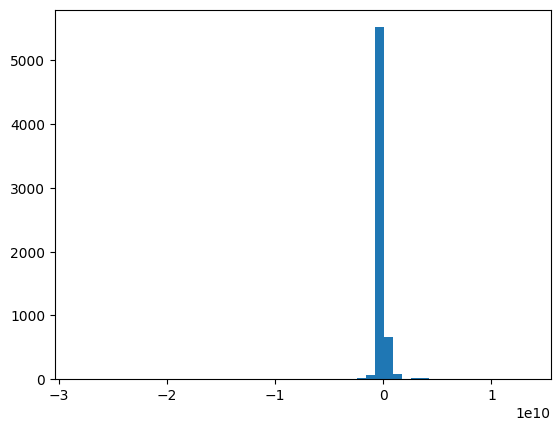

In [66]:
plt.hist(hpreact.view(-1).tolist(),50);

### SHEEEEEEESH that's big values -15 to 15

![image](4-makemore-pt3/Capture.PNG)
The video goes way more indepth about this ~16:00 but basically:

Our loss backpropagates through everything right? Our tanh gradient is (1-t**2) * out.grad, where t is the part where it gets 'squished", t= (e^(2x)-1)/(e^(2x)+1). And think about the graph of a tanh; how it flats out near -1, 1. If you had a t= 0, then your output would just be out.grad -- it lets your loss flow through perfectly! Anything else, and it begins inhibitting your *flows*. Especially near the tails, you'd get an ~0 gradient -- changing your inputs by a bit here would give a negligible change in the output of your tanh! So changing it would have no impact on the loss.

I.e the weights/biases of this  neuron have very little effect on the loss! i.e the gradients basically vanish for this little neuron. This kinda kills it!

I.e due to the tanh derivative here, the gradient flowing through tanh can only ever decrease the further it is from t=0. So if all the h's are close to -1, 1, then the gradients flowing through (backwards) through the network basically gets destroyed at this point because it'll be ~0 gradient; these neurons' weights/biases have no effect on the loss apparently. Dead neuron since it can't change well anymore! too activeeeee 

The concern is if a lot of neurons (from our tanh) output are -1, 1, then our gradients going through the NN get destroyed and it can't learn well anymore.



torch.Size([32, 200])

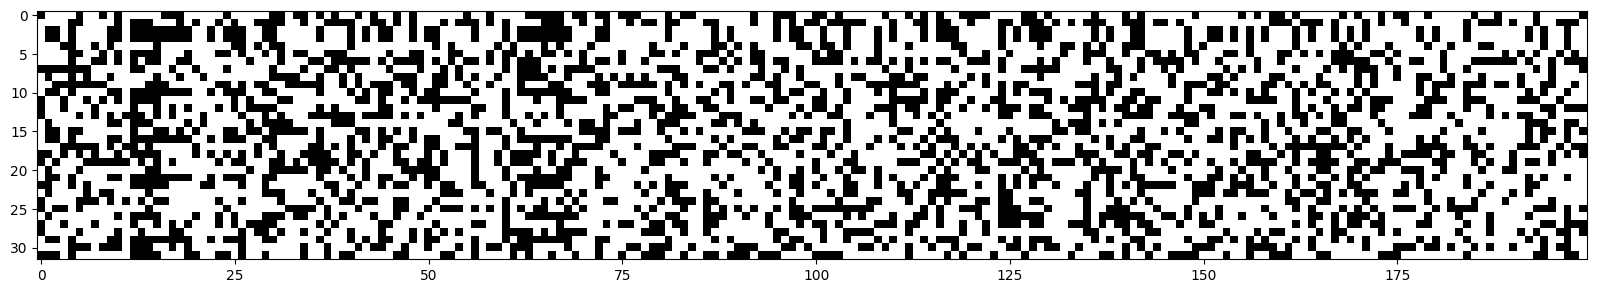

In [74]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # White is 'true', i.e a dead neuron!
h.shape # 200 neurons
# Basically, we'd be in trouble if an entire layer (column wise) was white (i.e dead neurons because those tanh neurons would be very active and in a flat tail --> gradients would get 'destroyed' by being so close to 0 -> wouldn't be able to learn well.).

# I.e: Tanh neuron s.t. no single example ever activates the tanh neuron in the 'active' part of the tanh. I.e if all its examples land in the tail (white) end. So our gradients will flow through and we will learn, will change, blahh.

# But yeah, the video explains this much better.

## Dead neurons can happen if you have a learning rate too high and they kinda "jump" into a dead spot, or it can happen by the random initialisation, just by chance they spawn in a shit spot. See the video!	

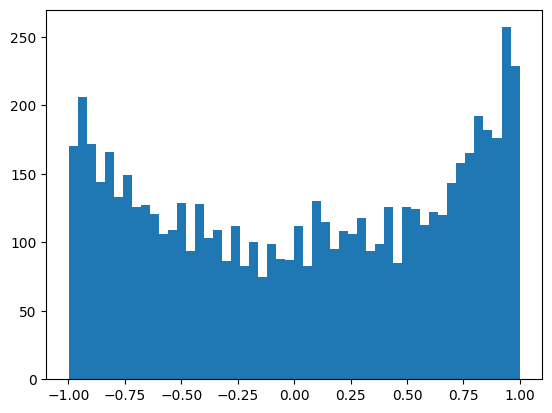

In [90]:
## So basically, the hpreact that goes into tanh is too large, too saturated in both sides of the tanh, so there's less training for the neurons since they update less frequently. After fixing by making W1, b1 smaller:
plt.hist(h.view(-1).tolist(),50);

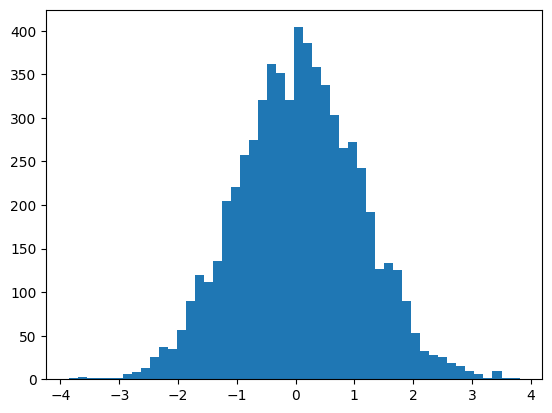

In [91]:
plt.hist(hpreact.view(-1).tolist(),50); # the stuff before it gets tanh'd.

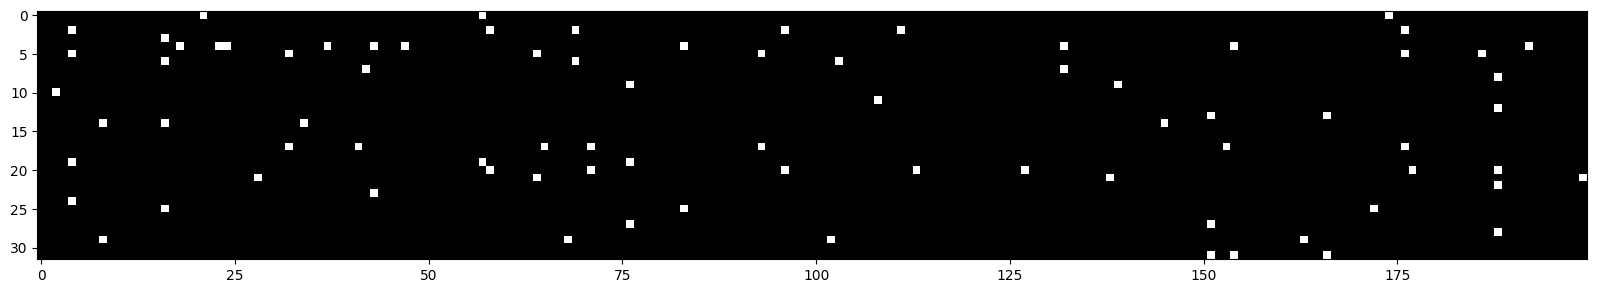

In [92]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# LMAOO -- because, there's no neurons saturated above 0.99. Okay, let's change * 0.1 to *0.2 for w1 lmao so we get *some*.

# loss log
Tl;dr -- Initialisation and its impact on performance. Just by tweaking a few things, look at our improvements! ~27:00

Since our network is small, we were still able to learn despite this, but the deeper/more complex your network is, it might get to a point where it'll barely/won't learn at all due to these initialisation errors. In general, initialisation and taking care of it is important!

(Obviously, this would be harder to fix by hand for complex stuff -- like... we legit put magic numbers in there, lmaoo. But that's for the next segment to talk about!! We can get shit to do it for us :o)

### original:
train 2.1245384216308594 val 2.168196439743042

### fix softmax confidently wrong:
No hockey stick! Start at a decent probability distribution you scoundrel! So we have more time to optimise instead of spending the first few thousand steps just massively 'squishing' our W2/b2 parameters.
train 2.07 val 2.13

### fix tanh layer too saturated at init:
So we don't have to spend as many cycles squashing down the weight matrix, (we do that in initialisation now :P) to fix our h values etc.. so our neurons can learn better.
train 2.0355966091156006 val 2.1026785373687744

#### Kraiming shit 
~28:00
....

36:00... Omfg, this guy just.. BRUH. Okay, so in the past, NNs were finnicky and shit and you had to really care about this stuff or else it wouldn't train well, but now it's less important since we have made advances like (which we'll get into future vids)
- residual connections
- ... normalisations (layer norm, batch norm, blah)
- better optimisers like Adam.